In [1]:
import matplotlib.pyplot as plt

# 予め資産として開発しておくモジュールorクラス

## 一般的な関数

マイナス側値とプラス側値をもつだけの構造体

In [2]:
class Side(): # マイナス側値とプラス側値をもつだけの構造体
    def __init__( self, mns, pls ):
        self.mns = mns
        self.pls = pls

#### 使用例

In [3]:
s = Side( mns = 10, pls = 20 )

In [4]:
s.mns

10

In [5]:
s.pls

20

## 物性値をリスト化して取得するクラス

In [6]:
class Prop():
    
    def __init__( self ):
        self.context = {
            'm' : {
                'cd'  : 1.0,
                'cap' : 100.0
            }
        }
    
    def search( self, name ):
        return self.context[name]


#### 使用例

In [7]:
p = Prop()

In [8]:
m = p.search('m')
m['cd'], m['cap']

(1.0, 100.0)

## 差分計算するクラス

In [9]:
class Cell():
    
    def __init__( self, cd, cap ):
        self.cd   = cd
        self.cap  = cap
        self.temp = 0.0
    
    def setInitialTemp( self, initial = 0.0 ):
        self.temp = initial
    
    def addAdjCell( self, adj ):
        self.adj = adj
        
    def makeCombinedConductance( self, surfCond ):
        cd_adj = Side( mns = surfCond.mns if self.adj.mns == 'AirMns' else self.adj.mns.cd.pls,
                       pls = surfCond.pls if self.adj.pls == 'AirPls' else self.adj.pls.cd.mns )
        R = Side( 1 / cd_adj.mns + 1 / self.cd.mns , 1 / cd_adj.pls + 1 / self.cd.pls )
        self.cc = Side( 1 / R.mns, 1 / R.pls  )
        
    def newTempCalc( self, sideTemp, deltaT ):
        temp_adj = Side( mns = sideTemp.mns if self.adj.mns == 'AirMns' else self.adj.mns.temp,
                         pls = sideTemp.pls if self.adj.pls == 'AirPls' else self.adj.pls.temp )
        heatflow = ( ( temp_adj.mns - self.temp ) * self.cc.mns + ( temp_adj.pls - self.temp ) * self.cc.pls ) * deltaT
        self.newtemp = heatflow / self.cap + self.temp
        
    def updatetemp( self ):
        self.temp = self.newtemp

        
class Wall():
                
    def __init__( self, initialtemp, surfCond, composition, material_prop, deltaT ):
        
        self.cells = [ Cell( cd = Side( mns = material_prop.search(c)['cd'], pls = material_prop.search(c)['cd'] ),
                            cap = material_prop.search(c)['cap'] ) for c in composition ]
        self.deltaT = deltaT
        
        # initialize temperature
        [ c.setInitialTemp( initialtemp ) for c in self.cells ]
    
        # set adjacent cell
        [ c.addAdjCell( Side(
            mns = 'AirMns' if i == 0                   else self.cells[i-1],
            pls = 'AirPls' if i == len(self.cells) - 1 else self.cells[i+1] ) ) for i, c in enumerate(self.cells) ]
    
        # make combined conductance
        [ c.makeCombinedConductance( surfCond = surfCond ) for c in self.cells ]
    
    def Calc( self, sideTemp ):
        [ c.newTempCalc( sideTemp = sideTemp, deltaT = self.deltaT ) for c in self.cells ]
        [ c.updatetemp() for c in self.cells ]

In [10]:
class logger():
    
    def __init__( self, interval ):
        self.interval = interval
        self.times = []

        self.datas = []
        self.titles = []
        self.objs = []
        self.sensors = []
        
    def AddSensor( self, title, obj, sensor ):
        self.datas.append( [] )
        self.titles.append( title )
        self.objs.append( obj )
        self.sensors.append( sensor )
        
    def WriteData( self, t ):
        if t % self.interval == 0:
            self.times.append( t )
            for ( d, o, s ) in zip( self.datas, self.objs, self.sensors ):
                d.append( s( o ) )        

ここより上半分は研究室の資産として持っておきます。  
上記は非常に汎用性が高い書き方をすることにします。  
下半分は、研究ごと、論文作成ごと、企業等からの依頼計算ごとに、その都度ごとに記述します。  
都度記述するので、一見めんどうくさそうに思えますが、下記の例のように、きちんと設計さえしさえば、たかだか10行程度で、複雑な計算が可能です。  
なんでもできるプログラムを作成するよりは、きちんと設計された再利用可能なモジュール郡を研究室で蓄積する方がコスパが高いと思います。

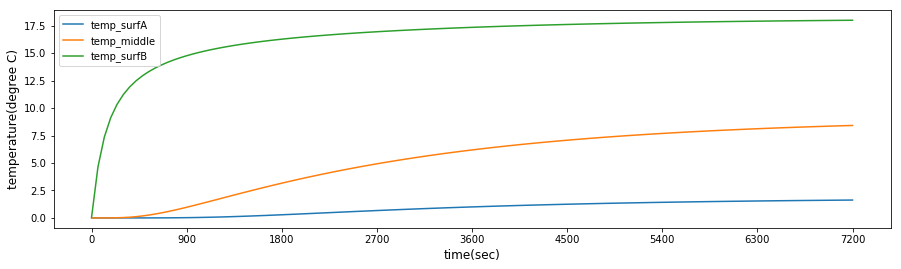

In [11]:
# make a wall
w = Wall( initialtemp   = 0.0,
          surfCond      = Side( mns = 1.0, pls = 1.0 ),
          composition   = ['m','m','m','m','m','m','m','m','m','m'],
          material_prop = Prop(),
          deltaT = 1.0 )
# initialtemp is the initial temperatures at the cells in the wall
# surfCond is the surface conductance at the both side surface of the wall (W/m2K)
# composition is the material of the cells in the wall
# material_porp is the material property list written in the dictionary style
# deltaT is the interval for calculation (s)

# set the logger with the interval of 60 sec.
l = logger( interval = 60 )
# set the sensors and connet them to the logger
l.AddSensor( title = 'temp_surfA',  obj = w, sensor = lambda w : w.cells[0].temp )
l.AddSensor( title = 'temp_middle', obj = w, sensor = lambda w : w.cells[4].temp )
l.AddSensor( title = 'temp_surfB',  obj = w, sensor = lambda w : w.cells[9].temp )

# calculation span
calcspan = 3600 * 2 + 1

# air temperature at the both side surface (℃)
# It is as constant value in this calculation, which is 5.0 degree C at the both side.
sideTemp = Side( mns = 0.0, pls = 20.0 )

# run calculation in 'calcspan' times
for t in range( calcspan ):
    w.Calc( sideTemp = sideTemp )
    l.WriteData( t )

# draw graph
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.plot( l.times, l.datas[0], label = l.titles[0] )
ax.plot( l.times, l.datas[1], label = l.titles[1] )
ax.plot( l.times, l.datas[2], label = l.titles[2] )
ax.set_xticks( [ n * 900 for n in range(0, 9) ] )
ax.set_xlabel( 'time(sec)', fontsize = 12 )
ax.set_ylabel( 'temperature(degree C)', fontsize = 12 )
plt.legend()
plt.show()